In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from splits import split_users # contains split_users func

pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 100)

In [2]:
# import time
# time.sleep(1200)
# print("slept 20 minutes")

In [3]:
# read in pickled DFs generated by query_dfs.py

df_orders = pd.read_pickle("./pickle/df_orders.pickle")
df_train = pd.read_pickle("./pickle/df_train.pickle")
df_prior = pd.read_pickle("./pickle/df_prior.pickle")
df_prod_detail = pd.read_pickle("./pickle/df_prod_detail.pickle")

In [4]:
# read in pickled feature DF generated by feature_engineering_1.ipynb
X = pd.read_pickle("./pickle/X_14.pickle")

In [5]:
X.sample(2)

,product_id,user_id,user_total_prod_orders,cart,in_cart,last_cart,in_last_cart,prod_prior_sales,prod_pct_reorders,prod_avg_atco,user_avg_ippo,days_since_prior_order,order_hour_of_day,user_avg_spacing
1614982,45066,150047,2,"[42244, 34551, 41055, 248, 44728, 35855, 25919...",0,"[42244, 34126, 22935, 14678, 260, 1511, 46313,...",0,79769,0.724818,7.391129,19.120000,7.0,8,7.463180
7616387,6065,59031,2,"[42240, 5151, 11636, 23909, 21641, 32313]",0,"[23909, 44548, 11456, 21024, 28204, 34024]",0,81,0.246914,6.506173,5.489796,6.0,14,7.622137


### Picking up where we left off...

**More. Features.**

* `up_streak`: how many times in a row has this user ordered this item?
    * this feature is very computationally expensive to add
    * implemented multiprocessing to complete in ~5 minutes. 
    * see `add_streaks.py` for details
    * converted to dummies
* `up_buy_streak`
    * one if buy_streak, else zero
* `up_no_buy_streak`
    * one if negative buy streak (purchased product, but not in past x orders), else 0
    
    


In [6]:
df_orders.dtypes

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

In [7]:
df_prior.sample()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cart,in_cart
4094991,720144,45066,3,1,142959,prior,5,0,0,15.0,"[20574, 24852, 45066, 28985, 17902, 49683, 243...",1


In [8]:
df_streaks = pd.read_csv("../data/order_streaks.csv")
df_streaks.rename(columns={"order_streak": "streak"}, inplace=True)
df_streaks.head(3)

,user_id,product_id,streak
0,1,196,5.0
1,1,12427,5.0
2,1,10258,5.0


Negative streaks indicate the number of weeks since the user last ordered the given product.

In [9]:
X = X.merge(df_streaks, how='left', on=['user_id', 'product_id'])

(array([510435., 629405., 804176., 968287.,      0., 982615., 189233.,
         83041.,  39380.,  64719.]),
 array([-4. , -3.1, -2.2, -1.3, -0.4,  0.5,  1.4,  2.3,  3.2,  4.1,  5. ]),
 <BarContainer object of 10 artists>)

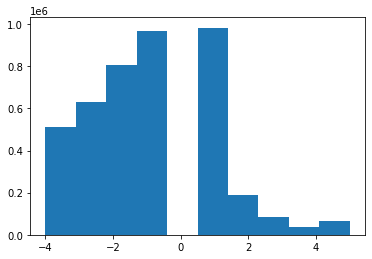

In [10]:
import matplotlib.pyplot as plt
plt.hist(X.streak)

In [11]:
X.streak.value_counts().sort_index()

-4.0    510435
-3.0    629405
-2.0    804176
-1.0    968287
 1.0    982615
 2.0    189233
 3.0     83041
 4.0     39380
 5.0     64719
Name: streak, dtype: int64

Awesome! Now we have an `order_streak` column. But if the user has never purchased the given item in the past, the resulting value is `NaN`. Since we have negative streaks that may help our model, we can't replace the `NaNs` with zeros.

Instead, let's consider this a categorical variable. Let's assign a value to the NaNs and then use pd.get_dummies to split the results.

In [12]:
mask = X.streak == np.NaN
X[mask].shape

(0, 15)

In [13]:
X['streak'] = X.streak.astype(str)
X['streak'] = X['streak'].fillna(value='NA')
X.head(3)

,product_id,user_id,user_total_prod_orders,cart,in_cart,last_cart,in_last_cart,prod_prior_sales,prod_pct_reorders,prod_avg_atco,user_avg_ippo,days_since_prior_order,order_hour_of_day,user_avg_spacing,streak
0,1,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,1852,0.613391,5.801836,4.625,1.0,12,10.4,-2.0
1,907,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2025,0.554568,3.653333,4.625,1.0,12,10.4,nan
2,1000,138,1,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2610,0.408046,9.503448,4.625,1.0,12,10.4,nan


In [14]:
dummies = pd.get_dummies(X.streak, prefix='streak', drop_first=True)
dummies.head(3)

,streak_-2.0,streak_-3.0,streak_-4.0,streak_1.0,streak_2.0,streak_3.0,streak_4.0,streak_5.0,streak_nan
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1


In [15]:
dumb_names = list(dummies.columns)
X[dumb_names] = pd.get_dummies(X.streak, prefix='streak', drop_first=True)
X.head(3)

,product_id,user_id,user_total_prod_orders,cart,in_cart,last_cart,in_last_cart,prod_prior_sales,prod_pct_reorders,prod_avg_atco,user_avg_ippo,days_since_prior_order,order_hour_of_day,user_avg_spacing,streak,streak_-2.0,streak_-3.0,streak_-4.0,streak_1.0,streak_2.0,streak_3.0,streak_4.0,streak_5.0,streak_nan
0,1,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,1852,0.613391,5.801836,4.625,1.0,12,10.4,-2.0,1,0,0,0,0,0,0,0,0
1,907,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2025,0.554568,3.653333,4.625,1.0,12,10.4,nan,0,0,0,0,0,0,0,0,1
2,1000,138,1,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2610,0.408046,9.503448,4.625,1.0,12,10.4,nan,0,0,0,0,0,0,0,0,1


In [16]:
buy_lambda = lambda x: 1 if x > 0 else 0

In [17]:
X['up_buy_streak'] = X.streak.astype(float).apply(buy_lambda)
# X.drop(columns='streak', inplace=True)

In [18]:
X.sample(5)

,product_id,user_id,user_total_prod_orders,cart,in_cart,last_cart,in_last_cart,prod_prior_sales,prod_pct_reorders,prod_avg_atco,user_avg_ippo,days_since_prior_order,order_hour_of_day,user_avg_spacing,streak,streak_-2.0,streak_-3.0,streak_-4.0,streak_1.0,streak_2.0,streak_3.0,streak_4.0,streak_5.0,streak_nan,up_buy_streak
4654479,20351,180664,1,"[17375, 35749, 25492, 8727, 20754, 45123, 1576...",0,"[15764, 17944, 2431, 44352]",0,32,0.312500,5.718750,5.941176,21.0,14,15.924731,-2.0,1,0,0,0,0,0,0,0,0,0
2366177,39275,21000,3,"[47209, 11520, 39928, 15290, 27292, 15336, 278...",0,"[49235, 11520, 16384, 13176, 47209, 36772, 778...",0,100060,0.628843,8.192694,20.574074,8.0,8,7.536364,-2.0,1,0,0,0,0,0,0,0,0,0
966740,11143,192596,1,"[23044, 1194]",0,"[47912, 12807, 43005]",0,2367,0.621462,7.121251,2.444444,3.0,15,1.701245,nan,0,0,0,0,0,0,0,0,1,0
8112105,24959,122981,1,"[44632, 24959]",1,[21709],0,469,0.558635,6.955224,2.040000,21.0,13,13.460000,-4.0,0,0,1,0,0,0,0,0,0,0
2579471,29311,93645,1,"[6292, 37067, 32655, 44008, 19049, 29623, 13984]",0,"[19049, 44008, 47209, 16083, 22935, 29103, 327...",0,3240,0.492593,10.239198,12.153846,30.0,15,18.007246,-1.0,0,0,0,0,0,0,0,0,0,0


In [19]:
X.shape

(8474661, 25)

### More. Features.

Can't stop, won't stop.

* `up_n5_n_buys`: user-product nearest/last 5 number of purchases
    * how many times did the user purchase the product in their last 5 orders?
    

* `up_n5_buy_ratio`: user-product nearest/last 5 buy ratio
    * this feature works very well in addition to above feature (at least for logreg)
    
    
* `up_atco_avg`: user-product average add-to-cart-order

In [20]:
mask = df_orders.eval_set == 'prior'
last_five = df_orders[mask]

last_five = last_five.groupby("user_id").tail(5)
last_five.groupby("order_id")
last_five.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [21]:
cols = ["order_id", "product_id", "in_cart", "reordered"]

last_five = last_five.merge(df_prior[cols], on='order_id')
last_five.head(5)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,in_cart,reordered
0,3367565,1,prior,6,2,7,19.0,196,1,1
1,3367565,1,prior,6,2,7,19.0,12427,1,1
2,3367565,1,prior,6,2,7,19.0,10258,1,1
3,3367565,1,prior,6,2,7,19.0,25133,1,1
4,550135,1,prior,7,1,9,20.0,196,1,1


In [22]:
stat_cols = ["user_id", "product_id", "order_number", "in_cart"]
n5_in_cart_sum = (last_five[stat_cols]
             .groupby(["user_id", "product_id"], as_index = False)
             .agg({"in_cart": 'sum'}))

n5_in_cart_sum.rename(columns={"in_cart": "up_n5_n_buys"}, inplace=True)

n5_in_cart_sum.head(12)

,user_id,product_id,up_n5_n_buys
0,1,196,5
1,1,10258,5
2,1,12427,5
3,1,13032,2
4,1,25133,5
5,1,35951,1
6,1,38928,1
7,1,39657,1
8,1,46149,3
9,1,49235,2


In [23]:
# confirm up_n5_n_buys looks correct
mask = (last_five.user_id == 1) & (last_five.product_id == 13032)
last_five[mask].head() # should only be two orders in output

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,in_cart,reordered
8,550135,1,prior,7,1,9,20.0,13032,1,1
28,2550362,1,prior,10,4,8,30.0,13032,1,1


In [24]:
X = X.merge(n5_in_cart_sum, how='left', on=['product_id', 'user_id'])

In [25]:
X['up_n5_n_buys'] = X.up_n5_n_buys.fillna(0)

In [26]:
# add up_n5_buy_ratio
X['up_n5_buy_ratio'] = X.up_n5_n_buys / 5
X.head(3)

,product_id,user_id,user_total_prod_orders,cart,in_cart,last_cart,in_last_cart,prod_prior_sales,prod_pct_reorders,prod_avg_atco,user_avg_ippo,days_since_prior_order,order_hour_of_day,user_avg_spacing,streak,streak_-2.0,streak_-3.0,streak_-4.0,streak_1.0,streak_2.0,streak_3.0,streak_4.0,streak_5.0,streak_nan,up_buy_streak,up_n5_n_buys,up_n5_buy_ratio
0,1,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,1852,0.613391,5.801836,4.625,1.0,12,10.4,-2.0,1,0,0,0,0,0,0,0,0,0,2.0,0.4
1,907,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2025,0.554568,3.653333,4.625,1.0,12,10.4,nan,0,0,0,0,0,0,0,0,1,0,0.0,0.0
2,1000,138,1,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2610,0.408046,9.503448,4.625,1.0,12,10.4,nan,0,0,0,0,0,0,0,0,1,0,0.0,0.0


In [27]:
df_prior.head(1)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cart,in_cart
0,114,24954,1,0,91891,prior,1,0,11,NaN,"[24954, 1688, 37371, 5782, 1263, 23763, 24385,...",1


In [28]:
# commenting these out because hurting F1 score for logreg....don't delete just yet.

# still think this should help.

# get up_atco_sum and up_atco_avg
cols = ['product_id', 'user_id', 'add_to_cart_order']

up_atco_sum = (df_prior[cols]
                     .groupby(["product_id", "user_id"], as_index=False)
                     .agg('sum'))

up_atco_avg = (df_prior[cols]
                     .groupby(["product_id", "user_id"], as_index=False)
                     .agg('mean'))

                           

up_atco_sum.rename(columns={"add_to_cart_order": "up_atco_sum"}, inplace=True)
up_atco_avg.rename(columns={"add_to_cart_order": "up_atco_avg"}, inplace=True)

up_atcos = up_atco_sum.merge(up_atco_avg, on=['product_id', 'user_id'])
del up_atco_sum
del up_atco_avg

up_atcos.head(10)

,product_id,user_id,up_atco_sum,up_atco_avg
0,1,138,6,3.000000
1,1,709,20,20.000000
2,1,764,21,10.500000
3,1,777,7,7.000000
4,1,825,2,2.000000
5,1,910,1,1.000000
6,1,1052,3,1.500000
7,1,1379,1,1.000000
8,1,1480,8,2.666667
9,1,1494,38,12.666667


In [29]:
up_atcos.shape

(13307953, 4)

In [30]:
X = X.merge(up_atcos, on=["product_id", "user_id"])
del up_atcos
X.head(3)

,product_id,user_id,user_total_prod_orders,cart,in_cart,last_cart,in_last_cart,prod_prior_sales,prod_pct_reorders,prod_avg_atco,user_avg_ippo,days_since_prior_order,order_hour_of_day,user_avg_spacing,streak,streak_-2.0,streak_-3.0,streak_-4.0,streak_1.0,streak_2.0,streak_3.0,streak_4.0,streak_5.0,streak_nan,up_buy_streak,up_n5_n_buys,up_n5_buy_ratio,up_atco_sum,up_atco_avg
0,1,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,1852,0.613391,5.801836,4.625,1.0,12,10.4,-2.0,1,0,0,0,0,0,0,0,0,0,2.0,0.4,6,3.0
1,907,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2025,0.554568,3.653333,4.625,1.0,12,10.4,nan,0,0,0,0,0,0,0,0,1,0,0.0,0.0,5,2.5
2,1000,138,1,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2610,0.408046,9.503448,4.625,1.0,12,10.4,nan,0,0,0,0,0,0,0,0,1,0,0.0,0.0,5,5.0


In [31]:
# from collections import OrderedDict
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score

# X_train, X_test, y_train, y_test = split_users(X)

# lr = LogisticRegression(solver='lbfgs', max_iter=200)
# lr.fit(X_train, y_train)
# f1_score(lr.predict(X_test), y_test)

In [32]:
X.shape

(8474661, 29)

In [33]:
X.to_pickle("pickle/X_25.pickle")

In [34]:
X.columns

Index(['product_id', 'user_id', 'user_total_prod_orders', 'cart', 'in_cart',
       'last_cart', 'in_last_cart', 'prod_prior_sales', 'prod_pct_reorders',
       'prod_avg_atco', 'user_avg_ippo', 'days_since_prior_order',
       'order_hour_of_day', 'user_avg_spacing', 'streak', 'streak_-2.0',
       'streak_-3.0', 'streak_-4.0', 'streak_1.0', 'streak_2.0', 'streak_3.0',
       'streak_4.0', 'streak_5.0', 'streak_nan', 'up_buy_streak',
       'up_n5_n_buys', 'up_n5_buy_ratio', 'up_atco_sum', 'up_atco_avg'],
      dtype='object')